In [535]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt # data visualization
import ipywidgets as widgets # interactive widgets
from ipywidgets import Box
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [577]:
#version = 1 # no genre and time signature values
#version = 2 # with new variables 
#version = 3 # data standartization 
#version = 4 # Feature Selection
#version = 5 # Cross Validation GridSearchCV
version = 6 # Deep Learning

In [537]:
# data loading and descriptive statistics
df = pd.read_csv('SpotifyFeatures.csv')

In [538]:
# update column values
df["genre"].replace({"Children's Music": "Children’s Music"}, inplace=True)
# general category
df["genre"].replace({"Soundtrack": "General","Movie":"General","Anime":"General","Children’s Music":"General","Comedy":"General"}, inplace=True)
# dance
df["genre"].replace({"Hip-Hop": "Dance","R&B":"dance","Dance":"Dance","Rap":"Dance","Pop":"Dance"}, inplace=True)
# folk
df["genre"].replace({"Folk": "Folk","Soul":"Folk","Blues":"Folk","Country":"Folk"}, inplace=True)
# Reggae
df["genre"].replace({"Reggaeton": "Reggae","Ska":"Reggae","Reggae":"Reggae","World":"Reggae"}, inplace=True)
# Alternative
df["genre"].replace({"Indie": "Alternative","Rock":"Alternative","Alternative":"Alternative","Electronic":"Alternative","Jazz":"Alternative"}, inplace=True)
# Reggae
df["genre"].replace({"Classical": "Classical","Opera":"Classical","A Capella":"Classical"}, inplace=True)

In [539]:
# for version +2
# create dummy variables
if version>=2:
    genre_df=pd.get_dummies(df["genre"]) 
    df = pd.concat([df,genre_df],axis=1) 

    # create dummy variables - time_signature
    time_signature_df=pd.get_dummies(df["time_signature"]) 
    df = pd.concat([df,time_signature_df],axis=1) 

    # remove old variables
    df.drop(['genre','time_signature','0/4','1/4'],axis=1, inplace=True)

In [540]:
# all versions
# Data cleaning and arrangement the data
df['mode'] = np.where(df['mode']=='Major', 1, 0) #change songs' mode (minor/major) to numerical

# change songs duration from milliseconds to seconds
df['duration_ms'] = df['duration_ms'] / 1000
df.rename(columns={'duration_ms': 'duration_s'}, inplace=True) # update column label

# drop variables:
df.drop_duplicates(subset=['track_id'], keep='first',inplace=True)
if version==1:
    df.drop(['artist_name','track_name','track_id','key','genre','time_signature'],axis=1, inplace=True)

elif version>=2:
    df.drop(['artist_name','track_name','track_id','key'],axis=1, inplace=True)

In [541]:
# versions +3
# data standardtization
# scale the dataset and make computations more efficient
if version ==3:
    features = ["duration_s","loudness","tempo","popularity"]
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        df[feature] = (df[feature]-mean)/std 

In [542]:
# feature selection - version +4
if version ==4:
    df.drop(['duration_s','mode','tempo','valence','5/4','Reggae'],axis=1, inplace=True)

In [543]:
# All versions
X= df.loc[:,df.columns !="popularity"]
y = df["popularity"]

In [544]:
# Data visualzation
#sample = df.sample(1000)
#sns.kdeplot(x = sample["acousticness"])
#sns.scatterplot(x=sample["acousticness"], y=sample["popularity"])
#sns.pairplot(sample[["acousticness","danceability"]])
#correlation_mat = df.corr()
#print(correlation_mat)
#sns.heatmap(correlation_mat)
#sns.scatterplot(sample["loudness"], sample["acousticness"], hue=sample["popularity"])
#sns.scatterplot(sample["acousticness"], sample["danceability"], size=sample["popularity"])
#g = sns.PairGrid(sample[[ "acousticness","popularity","genre"]], hue="genre")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend();

#df sample = diamonds.sample(3000)

In [545]:
# version 3
if version ==3:
    correlation_mat = df.corr()
    print(correlation_mat)
#sns.heatmap(correlation_mat,annot=True)

In [546]:
# version 4
if version ==4:
    sample = df.sample(500)
    #g = sns.pairplot(sample[["loudness", "acousticness", "popularity"]])
#sns.pairplot(sample[["danceability","loudness", "acousticness", "popularity"]],diag_kind="kde")
    #sns.pairplot(sample[["danceability","loudness", "acousticness", "popularity","genre"]], hue="genre")
"""
sns.pairplot(sample[["danceability","loudness", "acousticness", "popularity"]],diag_kind="kde")

acousticness = [0,1]
danceability = [0,1]
duration_s = [0,600]
energy = [0,1]
instrumentalness = [0,1]
liveness = [0,1]
loudness= [ -60,0]
speechiness = [0,1]
tempo = [0,250]
valence = [0,1]
mode = [0,1]
"""

'\nsns.pairplot(sample[["danceability","loudness", "acousticness", "popularity"]],diag_kind="kde")\n\nacousticness = [0,1]\ndanceability = [0,1]\nduration_s = [0,600]\nenergy = [0,1]\ninstrumentalness = [0,1]\nliveness = [0,1]\nloudness= [ -60,0]\nspeechiness = [0,1]\ntempo = [0,250]\nvalence = [0,1]\nmode = [0,1]\n'

In [547]:
# create a linear regression object
model_regression = linear_model.LinearRegression()

# create a random forest regression object
model_random_forest = RandomForestRegressor()

# create a random forest regression object
model_decision_tree = DecisionTreeRegressor()

In [548]:
# only on the first time
# MSE Track
if version == 1:
    regression_rmse = []
    random_forest_rmse = []
    decision_tree_rmse = []

    Phase = ['baseline','feature engineering','data standartization','feature selection','cross validation']


In [549]:
# separate the data to training and testing
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2)
# save as np.array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [550]:
# version 5
"""
if version ==5:
    folds = KFold(n_splits = 10, shuffle = True)
    hyper_params = [{'n_features_to_select': list(range(0,X.shape[1]))}] # specify range of hyperparameters
    model_regression.fit(X_train,y_train)
    rfe = RFE(model_regression) 
    model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)    

    # fit the model
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_) 
    y_pred = model_cv.predict(X_test)
    #model_regression.coef
    mse = mean_squared_error(y_test,y_pred)
"""

"\nif version ==5:\n    folds = KFold(n_splits = 10, shuffle = True)\n    hyper_params = [{'n_features_to_select': list(range(0,X.shape[1]))}] # specify range of hyperparameters\n    model_regression.fit(X_train,y_train)\n    rfe = RFE(model_regression) \n    model_cv = GridSearchCV(estimator = rfe, \n                        param_grid = hyper_params, \n                        scoring= 'r2', \n                        cv = folds, \n                        verbose = 1,\n                        return_train_score=True)    \n\n    # fit the model\n    model_cv.fit(X_train, y_train)\n    cv_results = pd.DataFrame(model_cv.cv_results_) \n    y_pred = model_cv.predict(X_test)\n    #model_regression.coef\n    mse = mean_squared_error(y_test,y_pred)\n"

In [551]:

# The models
if version ==5:    
    model_random_forest.fit(X_train,y_train)
    model_decision_tree.fit(X_train,y_train)
else:
    model_regression.fit(X_train,y_train)
    model_random_forest.fit(X_train,y_train)
    model_decision_tree.fit(X_train,y_train)



In [552]:
# version 5
if version == 5:
    hyper_params = [{'n_features_to_select': list(range(0, 18))}] # specify range of hyperparameters
    rfe = RFE(model_regression) 
    model_model_regression_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    model_model_regression_cv.fit(X_train, y_train)

    cv_results = pd.DataFrame(model_model_regression_cv.cv_results_)
   

Fitting 10 folds for each of 18 candidates, totalling 180 fits


c:\Users\Ido Leshem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ido Leshem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ido Leshem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\Ido Leshem\AppData\Local\Programs\Python\Pytho

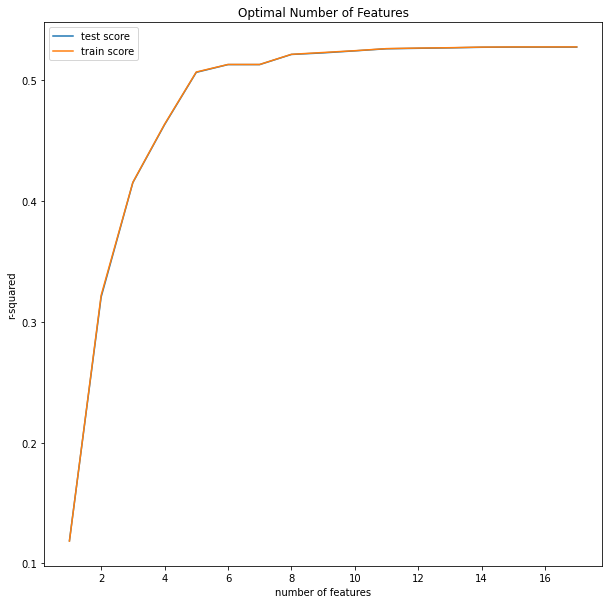

In [553]:
# version 5 
if version == 5:
    plt.figure(figsize=(10,10))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')

In [554]:
# not relevant
"""
# estimate the R² score on train data
print("Train data - the R^2 is",model_regression.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_regression.score(X_test,y_test))

# not relevant
# estimate the R² score on train data
print("Train data - the R^2 is",model_random_forest.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_random_forest.score(X_test,y_test))

# not relevant
# estimate the R² score on train data
print("Train data - the R^2 is",model_decision_tree.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_decision_tree.score(X_test,y_test))
"""

'\n# estimate the R² score on train data\nprint("Train data - the R^2 is",model_regression.score(X_train,y_train))\n# estimate the R² score on test data\nprint("Test data - the R^2 is",model_regression.score(X_test,y_test))\n\n# not relevant\n# estimate the R² score on train data\nprint("Train data - the R^2 is",model_random_forest.score(X_train,y_train))\n# estimate the R² score on test data\nprint("Test data - the R^2 is",model_random_forest.score(X_test,y_test))\n\n# not relevant\n# estimate the R² score on train data\nprint("Train data - the R^2 is",model_decision_tree.score(X_train,y_train))\n# estimate the R² score on test data\nprint("Test data - the R^2 is",model_decision_tree.score(X_test,y_test))\n'

In [555]:
# all versions
if version != 5:
    y_pred_reg = model_regression.predict(X_test)
if version == 5:
    y_pred_reg = model_model_regression_cv.predict(X_test)
y_pred_random_forset = model_random_forest.predict(X_test)
y_pred_decision_tree = model_decision_tree.predict(X_test)

#sns.regplot(y_test[0:100],y_pred_reg[0:100])
mse1 = mean_squared_error(y_test,y_pred_reg)

rmse1 = np.sqrt(mse1)

mse2 = mean_squared_error(y_test,y_pred_random_forset)
# we want smaller rmse
rmse2 = np.sqrt(mse2)


mse3 = mean_squared_error(y_test,y_pred_decision_tree)
# we want smaller rmse
rmse3 = np.sqrt(mse3)


regression_rmse.append(rmse1)
random_forest_rmse.append(rmse2)
decision_tree_rmse.append(rmse3)

In [556]:
"""
import matplotlib.pyplot as plt
test_samples = 10
regression = []
random_forest = []
decision_tree = []
ground_truth = []
for i in range(test_samples): 
    regression.append(model_regression.predict([X_test[i]])) 
    random_forest.append(model_random_forest.predict([X_test[i]]))
    decision_tree.append(model_decision_tree.predict([X_test[i]]))
    ground_truth.append(y_test[i])

plt.plot(range(len(regression)), regression, label='Linear Regression')
plt.plot(range(len(random_forest)), random_forest, label='Random Forest')
plt.plot(range(len(decision_tree)), decision_tree, label='Decision Tree')
plt.plot(range(len(ground_truth)), ground_truth, label='Ground Truth')
plt.xlim([0, test_samples])
plt.ylim([0, 100])
plt.xlabel('songs')
plt.ylabel('popularity')
plt.legend()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\ntest_samples = 10\nregression = []\nrandom_forest = []\ndecision_tree = []\nground_truth = []\nfor i in range(test_samples): \n    regression.append(model_regression.predict([X_test[i]])) \n    random_forest.append(model_random_forest.predict([X_test[i]]))\n    decision_tree.append(model_decision_tree.predict([X_test[i]]))\n    ground_truth.append(y_test[i])\n\nplt.plot(range(len(regression)), regression, label='Linear Regression')\nplt.plot(range(len(random_forest)), random_forest, label='Random Forest')\nplt.plot(range(len(decision_tree)), decision_tree, label='Decision Tree')\nplt.plot(range(len(ground_truth)), ground_truth, label='Ground Truth')\nplt.xlim([0, test_samples])\nplt.ylim([0, 100])\nplt.xlabel('songs')\nplt.ylabel('popularity')\nplt.legend()\nplt.show()\n"

In [557]:
"""
# Variables normalization
acousticness = [0,1]
danceability = [0,1]
duration_s = [0,600]
energy = [0,1]
instrumentalness = [0,1]
liveness = [0,1]
loudness= [ -60,0]
speechiness = [0,1]
tempo = [0,250]
valence = [0,1]
mode = [0,1]
features_range = {"acousticness":[0,1],"danceability" : [0,1],"duration_s":[0,600],"energy":[0,1],"instrumentalness":[0,1],"liveness":[0,1],"loudness": [-60,0],"speechiness" : [0,1],"tempo" : [0,250],"valence" : [0,1],"mode" : [0,1]}
"""

'\n# Variables normalization\nacousticness = [0,1]\ndanceability = [0,1]\nduration_s = [0,600]\nenergy = [0,1]\ninstrumentalness = [0,1]\nliveness = [0,1]\nloudness= [ -60,0]\nspeechiness = [0,1]\ntempo = [0,250]\nvalence = [0,1]\nmode = [0,1]\nfeatures_range = {"acousticness":[0,1],"danceability" : [0,1],"duration_s":[0,600],"energy":[0,1],"instrumentalness":[0,1],"liveness":[0,1],"loudness": [-60,0],"speechiness" : [0,1],"tempo" : [0,250],"valence" : [0,1],"mode" : [0,1]}\n'

In [558]:
"""
regression = [50]
random_forest = [50]
decision_tree = [50]
features = X.shape[1]
widgets_box = []
headers = X.columns
temp_sample =X.iloc[5]

#features_range["acousticness"][0]
for feature in range(features):
    
    temp_widget = widgets.FloatSlider(
    value=temp_sample[feature],
    min=features_range[headers[feature]][0],
    max=features_range[headers[feature]][1],
    step=0.1,
    description=headers[feature],
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
    )
    widgets_box.append(temp_widget)


box = Box(children=widgets_box)
box 
"""

'\nregression = [50]\nrandom_forest = [50]\ndecision_tree = [50]\nfeatures = X.shape[1]\nwidgets_box = []\nheaders = X.columns\ntemp_sample =X.iloc[5]\n\n#features_range["acousticness"][0]\nfor feature in range(features):\n    \n    temp_widget = widgets.FloatSlider(\n    value=temp_sample[feature],\n    min=features_range[headers[feature]][0],\n    max=features_range[headers[feature]][1],\n    step=0.1,\n    description=headers[feature],\n    disabled=False,\n    continuous_update=False,\n    orientation=\'vertical\',\n    readout=True,\n    readout_format=\'.1f\',\n    )\n    widgets_box.append(temp_widget)\n\n\nbox = Box(children=widgets_box)\nbox \n'

In [559]:
"""
for feature in range(features): 
    temp_sample[feature] = widgets_box[feature].value
"""

'\nfor feature in range(features): \n    temp_sample[feature] = widgets_box[feature].value\n'

In [560]:
"""
regression.append(model_regression.predict([temp_sample])) 
random_forest.append(model_random_forest.predict([temp_sample]))
decision_tree.append(model_decision_tree.predict([temp_sample]))

# Plot a simple line chart
plt.plot(range(len(regression)), regression, label='Linear Regression')
plt.plot(range(len(random_forest)), random_forest, label='Random Forest')
plt.plot(range(len(decision_tree)), decision_tree, label='Decision Tree')
plt.xlim([0, len(regression)])
plt.ylim([0, 100])
plt.legend()
plt.show()
"""

"\nregression.append(model_regression.predict([temp_sample])) \nrandom_forest.append(model_random_forest.predict([temp_sample]))\ndecision_tree.append(model_decision_tree.predict([temp_sample]))\n\n# Plot a simple line chart\nplt.plot(range(len(regression)), regression, label='Linear Regression')\nplt.plot(range(len(random_forest)), random_forest, label='Random Forest')\nplt.plot(range(len(decision_tree)), decision_tree, label='Decision Tree')\nplt.xlim([0, len(regression)])\nplt.ylim([0, 100])\nplt.legend()\nplt.show()\n"

In [587]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu,input_shape=[X.shape[1]]),
        layers.Dense(64, activation = tf.nn.relu),
        layers.Dense(1)

    ])
    optimizer = tf.keras.optimizers.RMSprop(.001)
    model.compile(loss="mse",optimizer=optimizer,metrics=['mae','mse']) # examine our model
    return model
model = build_model()

In [588]:
if version ==6:
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1408      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [589]:
if version == 6:
    # train the model
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs):
            if epoch % 100==0: print("")
            print('.',end="")

    EPOCHS = 500
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    history = model.fit(
        X,y, epochs = EPOCHS,validation_split = 0.2, verbose = 0,callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [564]:
"""
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
"""

"\nhist = pd.DataFrame(history.history)\nhist['epoch'] = history.epoch\nhist.tail()\n"

In [565]:
if version == 6:
    def plot_history(history):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error')
        plt.plot(hist['epoch'], hist['mae'],label='Train Error')
        plt.plot(hist['epoch'],hist['val_mae'],label='Validation Error')
        plt.legend()
        plt.ylim([0,1])
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.plot(hist['epoch'], hist['mse'],label='Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
        plt.legend()
        plt.ylim([0,1])
    plot_history(history)   

1105/1105 [==============================] - 2s 2ms/step


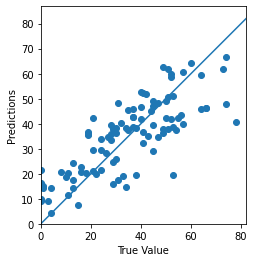

In [596]:
if version ==6:
    loss, mae, mse = model.evaluate(X_test,y_test,verbose=0)
    rmse_DL =  np.sqrt(mse)
    dl = [np.nan,np.nan,np.nan,np.nan,np.nan]
    dl.append(rmse_DL)




test_predictions = model.predict(X_test).flatten()
plt.scatter(y_test[0:100], test_predictions[0:100])
plt.xlabel("True Value")
plt.ylabel("Predictions")
plt.axis('equal')
plt.axis('Square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])


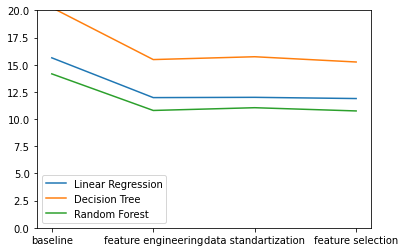

[15.634710729287956, 11.975218292456146, 12.000237598033712, 11.889231239972283] [20.25346896787413, 15.473930725420058, 15.734280921864858, 15.249918810524482] [14.159450764830785, 10.792814600585421, 11.04594021641657, 10.748570225943]
[nan, nan, nan, nan, nan, 11.329917018818819]


In [593]:
# Models' Mean Squared Error


plt.plot(Phase[0:len(regression_rmse)], regression_rmse, label='Linear Regression')
plt.plot(Phase[0:len(regression_rmse)], decision_tree_rmse, label='Decision Tree')
plt.plot(Phase[0:len(regression_rmse)], random_forest_rmse, label='Random Forest')
#if version == 6:
    #plt.plot(Phase, dl, label='dl',linewidth=2,marker="*")
plt.xticks(Phase[0:len(regression_rmse)])
plt.ylim([0, 20])
plt.legend()
plt.show()
print(regression_rmse,decision_tree_rmse,random_forest_rmse)
print(dl)


In [568]:
"""
# not relevant
# create a random forest regression object
model_random_forest = RandomForestRegressor(n_estimators = 200)

model_random_forest.fit(X_train,y_train)
# estimate the R² score on train data
print("Train data - the R^2 is",model_random_forest.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_random_forest.score(X_test,y_test))
"""

'\n# not relevant\n# create a random forest regression object\nmodel_random_forest = RandomForestRegressor(n_estimators = 200)\n\nmodel_random_forest.fit(X_train,y_train)\n# estimate the R² score on train data\nprint("Train data - the R^2 is",model_random_forest.score(X_train,y_train))\n# estimate the R² score on test data\nprint("Test data - the R^2 is",model_random_forest.score(X_test,y_test))\n'